# Tau trigger BDT notebook

### Standard import

In [50]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump,load
import time
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [51]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.2.


In [52]:
! ls -lhtr /eos/user/a/adsalvad/Hplnn/
! ls -lhtr
#import root_pandas

total 109M
-rw-r--r--. 1 adsalvad 1307 49M Mar 18 16:29 pandas_INC_ge6jge4b.h5
-rw-r--r--. 1 adsalvad 1307 61M Jun 25 17:51 trigger_test.h5
total 292M
-rw-r--r--. 1 adsalvad 1307  756 Jun 26 13:48 createHDF.py
-rw-r--r--. 1 adsalvad 1307 291M Jun 26 13:48 pandas_trigger.h5
-rw-r--r--. 1 adsalvad 1307  474 Jun 26 13:48 setup.sh
-rw-r--r--. 1 adsalvad 1307 1.5K Jun 26 23:22 TMVAplots.py
drwxr-xr-x. 2 adsalvad 1307 4.0K Jun 26 23:28 __pycache__
-rw-r--r--. 1 adsalvad 1307 1.3K Jun 27 11:58 README.md
-rw-r--r--. 1 adsalvad 1307 107K Jul  4 07:05 BDTtest.ipynb
-rw-r--r--. 1 adsalvad 1307  902 Jul  5 22:14 optimiseweightAUC.txt~
-rw-r--r--. 1 adsalvad 1307  22K Jul  5 23:39 HpHyperParameterOptimisation.py
-rw-r--r--. 1 adsalvad 1307  16K Jul  6 02:01 optimiseweight.txt~
-rw-r--r--. 1 adsalvad 1307 2.5K Jul  6 12:45 optimiseweight.txt
-rw-r--r--. 1 adsalvad 1307 1.8K Jul  6 12:48 optimiseweightAUC.txt
drwxr-xr-x. 2 adsalvad 1307 4.0K Jul  6 23:13 results
drwxr-xr-x. 2 adsalvad 1307 4.0K Jul  

### Read the pandas file

In [53]:
df_mc = pd.read_hdf('pandas_trigger.h5')
df_mc["Weight"] = 1.0 #keep it flexible
#the file can be written in lots of different ways, and including samples and other info accessible with keys

### Check events

In [4]:
df_mc.head()

Coretrack_nSiHoles  Coretrack_signalv8  Coretrack_z0  Coretrack_signalv1  \
0                   0                   1    -13.694421                   1   
1                   0                  -1   -100.047989                  -1   
2                   1                  -1    -62.319122                  -1   
3                   2                  -1    -97.825089                  -1   
4                   2                   0    179.047913                   0   

   Coretrack_pt  Coretrack_ratioptCalo  EventNumber  Coretrack_nPiHits  \
0  26539.250000               0.910458     60000393                  5   
1    774.340820              -1.000000     60000393                  1   
2    555.448608              -1.000000     60000393                  5   
3   1123.344360              -1.000000     60000393                  2   
4   1149.612915               0.039439     60000393                  2   

   Coretrack_dRleadtrk  Coretrack_d0  Coretrack_dR  __array_index  Weight  
0             0.000000      0.014015      0.012274              0     1.0  
1            -1.000000     14.720797     -1.000000              1     1.0  
2            -1.000000    -10.068580     -1.000000              2     1.0  
3            -1.000000     -1.563127     -1.000000              3     1.0  
4             0.096081      0.976296      0.095885              4     1.0

### Some definitions

In [54]:
features_names = ["Coretrack_pt","Coretrack_z0","Coretrack_d0","Coretrack_nPiHits","Coretrack_nSiHoles","Coretrack_ratioptCalo","Coretrack_dR","Coretrack_dRleadtrk"]

### Prepare sample for splitting

In [55]:
df_mc=df_mc[df_mc.Coretrack_signalv8!=-1] #keep selected entries for the training
df_mc.reset_index(inplace = True, drop = True) #resseting index here 
df_mc.head(1)

Coretrack_nSiHoles  Coretrack_signalv8  Coretrack_z0  Coretrack_signalv1  \
0                   0                   1    -13.694421                   1   

   Coretrack_pt  Coretrack_ratioptCalo  EventNumber  Coretrack_nPiHits  \
0      26539.25               0.910458     60000393                  5   

   Coretrack_dRleadtrk  Coretrack_d0  Coretrack_dR  __array_index  Weight  
0                  0.0      0.014015      0.012274              0     1.0

In [56]:
nbkg=df_mc[df_mc.Coretrack_signalv8==0].shape[0]
nsignal=df_mc[df_mc.Coretrack_signalv8==1].shape[0]
print('ratio signal/bkg: ',nsignal/nbkg , " (",nsignal,"/",nbkg,")")
print('signal ratio', nsignal/(nbkg+nsignal))

ratio signal/bkg:  0.4016427994447538  ( 409711 / 1020088 )
signal ratio 0.28655146632498696


In [57]:
from sklearn.utils import shuffle
random_state = 123456789
df_mc = shuffle(df_mc,random_state = random_state)
df_mc["Coretrack_z0"]=df_mc["Coretrack_z0"].apply(abs)
df_mc["Coretrack_d0"]=df_mc["Coretrack_d0"].apply(abs)
df_mc["Coretrack_pt"]=df_mc["Coretrack_pt"].apply(np.log)
df_mc["Coretrack_ratioptCalo"]=df_mc["Coretrack_ratioptCalo"].apply(np.log)


df_even = df_mc[df_mc.EventNumber%2==0]
df_odd = df_mc[df_mc.EventNumber%2==1]

In [58]:
def getxyw(df,features,ycolumn):
    X = df.loc[:,features].copy()
    y = df[ycolumn].copy()
    w = df["Weight"].copy()
    #for obj in [X,y,w]: obj.reset_index(inplace = True, drop = True) reset index
    return X, y, w
X_train, y_train, w_train = getxyw(df_even,features_names,"Coretrack_signalv8")
X_test, y_test, w_test = getxyw(df_odd,features_names,"Coretrack_signalv8")
print ("even:", w_train[y_train==1].sum()/w_train[y_train==0].sum() ,w_train[y_train==1].sum()/(w_train[y_train==0].sum()+w_train[y_train==1].sum()) )
print ("odd:", w_test[y_test==1].sum()/w_test[y_test==0].sum() ,w_test[y_test==1].sum()/(w_test[y_test==0].sum()+w_test[y_test==1].sum()) )
df_mc.head()

even: 0.4015092533941532 0.286483483731402
odd: 0.4017762811001104 0.28661940319378026


Coretrack_nSiHoles  Coretrack_signalv8  Coretrack_z0  \
1003585                   1                   0     58.303303   
899554                    1                   0     61.826046   
600238                    0                   1     16.621363   
1062171                   5                   0     50.333900   
1011795                   3                   0    219.223923   

         Coretrack_signalv1  Coretrack_pt  Coretrack_ratioptCalo  EventNumber  \
1003585                   0      7.075783              -4.259779     61021806   
899554                    0      6.944490              -4.305910     60818022   
600238                    1     10.202984              -0.324974     60580423   
1062171                   0      7.535610              -4.047593     61442954   
1011795                   0      7.900557              -2.667933     61179519   

         Coretrack_nPiHits  Coretrack_dRleadtrk  Coretrack_d0  Coretrack_dR  \
1003585                  2             0.072082      0.009391      0.082525   
899554                   1             0.107464      7.003039      0.114692   
600238                   5             0.000000      0.175403      0.026888   
1062171                  2             0.094440      0.433980      0.101213   
1011795                  2             0.145573      0.502215      0.102574   

         __array_index  Weight  
1003585             16     1.0  
899554              27     1.0  
600238               0     1.0  
1062171             15     1.0  
1011795              7     1.0

In [59]:
X_train.head() # you can check if its working or not

Coretrack_pt  Coretrack_z0  Coretrack_d0  Coretrack_nPiHits  \
1003585      7.075783     58.303303      0.009391                  2   
899554       6.944490     61.826046      7.003039                  1   
1062171      7.535610     50.333900      0.433980                  2   
212839       8.757286    220.574417      3.331862                  0   
1084463     11.475793     13.256835      0.028876                  4   

         Coretrack_nSiHoles  Coretrack_ratioptCalo  Coretrack_dR  \
1003585                   1              -4.259779      0.082525   
899554                    1              -4.305910      0.114692   
1062171                   5              -4.047593      0.101213   
212839                    0              -1.906107      0.084301   
1084463                   0              -0.120523      0.019602   

         Coretrack_dRleadtrk  
1003585             0.072082  
899554              0.107464  
1062171             0.094440  
212839              0.080462  
1084463             0.000000

### Weight transformer

In [60]:
signalratio=0.6
for label,ratio in zip([0,1],[1.-signalratio,signalratio]):
    print("-->bkg" if label==0 else "--> signal")
    sumweight = w_train[y_train==label].sum()
    print("sumweight",sumweight,end='')
    wscale=ratio/sumweight
    print(", scale", wscale,end="")
    w_train[y_train==label]*=wscale
    print("newsumweight:",w_train[y_train==label].sum())
print("Totalweight:", w_train.sum())

-->bkg
sumweight 509921.0, scale 7.84435236046368e-07newsumweight: 0.3999999999999997
--> signal
sumweight 204738.0, scale 2.930574685695865e-06newsumweight: 0.5999999999999999
Totalweight: 1.0000000000000002


### Get BDT and training it

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
def getBDT(options={}):
    """ Standard BDT classifier based on GradienBoosting"""
    bdt = GradientBoostingClassifier(n_estimators=250,
                                    learning_rate=0.2,
                                    max_depth=5,
                                    min_weight_fraction_leaf=0.01,
                                    random_state=0)
    bdt.set_params(**options)
    return bdt

In [62]:
classifier = getBDT()

In [63]:
!date
classifier.fit(X_train,y_train, sample_weight = w_train)
!date

Sun Jul  7 16:47:24 CEST 2019
Sun Jul  7 16:53:16 CEST 2019


### Some validation

In [16]:
#AUC for each boosting
#test = np.empty(len(classifier.estimators_))
#for i, pred in enumerate(classifier.staged_predict_proba(X_test)):
#    test[i]=1.-roc_auc_score(y_test,pred[:,1], sample_weight = w_test)
    
#train = np.empty(len(classifier.estimators_))
#for i, pred in enumerate(classifier.staged_predict_proba(X_train)):
#    train[i]=1.-roc_auc_score(y_train,pred[:,1], sample_weight = w_train)


In [68]:
#AUC
test = 1.-roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1], sample_weight = w_test)
train = 1.-roc_auc_score(y_train,classifier.predict_proba(X_train)[:,1], sample_weight = w_train)
print (1.-test, 1.-train)

0.9991817876186232 0.9993485716810143


In [72]:
print(test, train) #abs/ln, signal weight 0.6
print((0.598/0.591817876)*100)

0.0008182123813768039 0.0006514283189856807
101.04459906513537


### Save BDT and training

In [66]:
dump(classifier,"models/BDT_t250l02d5_w06.sav")

['models/BDT_t250l02d5_w06.sav']

In [67]:
!ls models
!mv models/BDT_default_w06.sav models/BDT_t120l013d5_w06.sav

BDT_default_w06.sav    learningcurveAUCs_w06.sav   learningratesAUCs_w06.sav
BDT_t250l02d5_w06.sav  learningdepthsAUCs_w06.sav


In [32]:
testclass=load("models/BDT_t250l02d5_w06.sav")

In [34]:
test2 = 1.-roc_auc_score(y_test,testclass.predict_proba(X_test)[:,1], sample_weight = w_test)
train2 = 1.-roc_auc_score(y_train,testclass.predict_proba(X_train)[:,1], sample_weight = w_train)
test2,train2,roc_auc_score(y_test,testclass.predict_proba(X_test)[:,1], sample_weight = w_test)

(0.0008966960942862201, 0.0008322000365668103, 0.9991033039057138)

# Optimisation things

### Optimise weights

In [80]:
with open("optimiseweight.txt",'a') as outfile:
    #outfile.write("Ratio\ttest 1-AUC\t\ttrain 1-AUC\n")
    for signalratio in np.arange(0.5,0.91,0.01):
        print ("Trying ratio:",signalratio)
        for label,ratio in zip([0,1],[1.-signalratio,signalratio]):
            print("-->bkg" if label==0 else "--> signal")
            sumweight = w_train[y_train==label].sum()
            print("sumweight",sumweight,end='')
            wscale=ratio/sumweight
            print(", scale", wscale,end="")
            w_train[y_train==label]*=wscale
            print("newsumweight:",w_train[y_train==label].sum())
        print("Totalweight:", w_train.sum())
        !date
        classifier.fit(X_train,y_train, sample_weight = w_train)
        !date
        test = 1.-roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1], sample_weight = w_test)
        train = 1.-roc_auc_score(y_train,classifier.predict_proba(X_train)[:,1], sample_weight = w_train)
        print("For",signalratio,test,train)
        outfile.write(str(signalratio)+"\t"+str(test)+"\t"+str(train)+"\n")

Trying ratio: 0.5
-->bkg
sumweight 0.5000000000000003, scale 0.9999999999999993newsumweight: 0.5000000000000003
--> signal
sumweight 0.5000000000000002, scale 0.9999999999999996newsumweight: 0.5000000000000001
Totalweight: 1.0000000000000004
Fri Jul  5 23:21:30 CEST 2019
Fri Jul  5 23:24:21 CEST 2019
For 0.5 0.000910820632832432 0.0008430548523541415
Trying ratio: 0.51
-->bkg
sumweight 0.5000000000000003, scale 0.9799999999999993newsumweight: 0.48999999999999927
--> signal
sumweight 0.5000000000000001, scale 1.0199999999999998newsumweight: 0.5099999999999997
Totalweight: 0.9999999999999997
Fri Jul  5 23:24:25 CEST 2019
Fri Jul  5 23:27:19 CEST 2019
For 0.51 0.0009013141431858385 0.000834182436876385
Trying ratio: 0.52
-->bkg
sumweight 0.48999999999999927, scale 0.9795918367346953newsumweight: 0.4800000000000002
--> signal
sumweight 0.5099999999999997, scale 1.0196078431372555newsumweight: 0.5200000000000002
Totalweight: 1.0000000000000009
Fri Jul  5 23:27:23 CEST 2019
Fri Jul  5 23:30:

sumweight 0.7100000000000003, scale 1.0140845070422533newsumweight: 0.7199999999999996
Totalweight: 1.0
Sat Jul  6 00:26:10 CEST 2019
Sat Jul  6 00:29:13 CEST 2019
For 0.7200000000000002 0.0009207913931706946 0.0008529622322588359
Trying ratio: 0.7300000000000002
-->bkg
sumweight 0.28000000000000025, scale 0.9642857142857127newsumweight: 0.2699999999999999
--> signal
sumweight 0.7199999999999996, scale 1.0138888888888897newsumweight: 0.7300000000000008
Totalweight: 1.0000000000000004
Sat Jul  6 00:29:17 CEST 2019
Sat Jul  6 00:32:06 CEST 2019
For 0.7300000000000002 0.0009086792011226974 0.0008366622404120116
Trying ratio: 0.7400000000000002
-->bkg
sumweight 0.2699999999999999, scale 0.9629629629629625newsumweight: 0.2599999999999999
--> signal
sumweight 0.7300000000000008, scale 1.0136986301369855newsumweight: 0.7400000000000001
Totalweight: 0.9999999999999993
Sat Jul  6 00:32:10 CEST 2019
Sat Jul  6 00:35:02 CEST 2019
For 0.7400000000000002 0.0009105470660922821 0.0008424298631615201


0.09 test
0.09999999999999999 0.0009574114719388405
0.10999999999999999 0.0009594794555641828
0.11999999999999998 0.0009520767866233459
0.12999999999999998 0.000938597726730328
0.13999999999999996 0.0009493668960991464
0.14999999999999997 0.000936290244303084
0.15999999999999998 0.0009348222628169367
0.16999999999999996 0.0009314945161629229
0.17999999999999994 0.0009124312071688845
0.18999999999999995 0.000916893356400883
0.19999999999999996 0.0008992842248035648
0.20999999999999994 0.0009136185692538712
0.21999999999999995 0.0009225066481207689
0.22999999999999993 0.0009065883716574685
0.2399999999999999 0.0009110629526987157
0.24999999999999992 0.0009118593630770278
0.2599999999999999 0.0009171377609862308
0.2699999999999999 0.0009123813556144444
0.2799999999999999 0.0009033771253990075
0.2899999999999999 0.0009082781127102146
0.29999999999999993 0.0009009583209027561
0.3099999999999999 0.0009060351274645662
0.31999999999999984 0.0009119691168252286
0.32999999999999985 0.00090513021

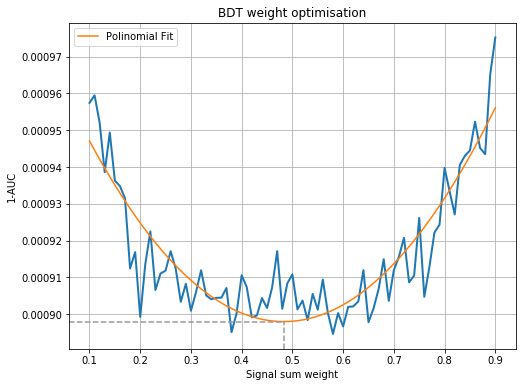

In [26]:
import numpy.polynomial.polynomial as poly
aucs=[]
wpoints=np.arange(0.09,0.91,0.01)
i = 0
with open('optimiseweightAUC.txt','r') as infile:
    for preline in infile:
        aucs.append(preline.split()[0])
        print(wpoints[i],preline.split()[0])
        i+=1
aucs=aucs[1:]
wpoints = wpoints[1:]
aucs = [float(x) for x in aucs]
wpoints=np.arange(0.1,0.91,0.01)
print(len(wpoints),len(aucs))
coefs = poly.polyfit(wpoints,aucs,2)
x_new=np.arange(0.1,0.901,0.001)
ffit = poly.polyval(x_new, coefs)

min_y = min(ffit)  # Find the maximum y value
min_x = x_new[ffit.argmin()]  # Find the x value corresponding to the maximum y value
print (min_x, min_y)


plt.figure(figsize=(8,6))
plt.plot(wpoints,aucs,lw=2)
plt.plot(x_new, ffit,label='Polinomial Fit')
axes = plt.gca()
#plt.plot([min(wpoints), max(wpoints)], [min(aucs), max(aucs)], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.ylim(axes.get_ylim())
plt.xlim(axes.get_xlim())
plt.plot([min_x,min_x],[axes.get_ylim()[0], min_y], '--', color=(0.6, 0.6, 0.6))
plt.plot([axes.get_xlim()[0],min_x],[min_y, min_y], '--', color=(0.6, 0.6, 0.6))
#plt.xlim([0.0008, 0.00091])
print(min(aucs), max(aucs))
#plt.ylim([0.0008, 0.0010])
plt.title('BDT weight optimisation')
plt.xlabel('Signal sum weight')
plt.ylabel('1-AUC')
plt.legend()
plt.grid()
print(axes.get_ylim())
plt.show()


### Learning curve

In [85]:
def scaleweight(w_train,y_train):
    signalratio=0.6
    for label,ratio in zip([0,1],[1.-signalratio,signalratio]):
        print("-->bkg" if label==0 else "--> signal")
        sumweight = w_train[y_train==label].sum()
        print("sumweight",sumweight,end='')
        wscale=ratio/sumweight
        print(", scale", wscale,end="")
        w_train[y_train==label]*=wscale
        print("newsumweight:",w_train[y_train==label].sum())
    print("Totalweight:", w_train.sum())
    return w_train

def getBDTlc(options={}):
    """ Standard BDT classifier based on GradienBoosting"""
    bdt = GradientBoostingClassifier(n_estimators=120,
                                    learning_rate=0.13,
                                    max_depth=5,
                                    min_weight_fraction_leaf=0.01,
                                    random_state=0)
    bdt.set_params(**options)
    return bdt

In [93]:
print(X_train.shape)
print(0.5*X_train.shape[0])
print(X_train[:int(0.5*X_train.shape[0])].shape)


(714659, 8)
357329.5
(357329, 8)


In [94]:
trainpoints = np.linspace(0.1,1.0,10)
learningcurveAUCs = {}
learningcurveAUCs["train"]=[]
learningcurveAUCs["test"]=[]
for trainpoint in trainpoints:
    print("Original size",df_mc.shape[0], "target size",df_mc.shape[0]*trainpoint)
    print(df_mc[:int(trainpoint*df_mc.shape[0])].shape)
    dfr_mc=df_mc[:int(trainpoint*df_mc.shape[0])].copy()
    dfr_even = dfr_mc[dfr_mc.EventNumber%2==0]
    dfr_odd = dfr_mc[dfr_mc.EventNumber%2==1]
    Xr_train, yr_train, wr_train = getxyw(dfr_even,features_names,"Coretrack_signalv8")
    Xr_test,yr_test,wr_test = getxyw(dfr_odd,features_names,"Coretrack_signalv8")
    wr_train = scaleweight(wr_train,yr_train)
    lc_clf = getBDT()
    print("Starting",trainpoint,time.ctime(),end="")
    lc_clf.fit(Xr_train,yr_train, sample_weight = wr_train)
    print("-->",time.ctime())

    test = 1.-roc_auc_score(yr_test,lc_clf.predict_proba(Xr_test)[:,1], sample_weight = wr_test)
    train = 1.-roc_auc_score(yr_train,lc_clf.predict_proba(Xr_train)[:,1], sample_weight = wr_train)
    print(test,train)
    learningcurveAUCs["train"].append(train)
    learningcurveAUCs["test"].append(test)

Original size 1429799 target size 142979.9
(142979, 13)
-->bkg
sumweight 51174.0, scale 7.816469300816821e-06newsumweight: 0.39999999999999986
--> signal
sumweight 20245.0, scale 2.9636947394418374e-05newsumweight: 0.6000000000000001
Totalweight: 1.0
Starting 0.1 Sun Jul  7 17:35:40 2019--> Sun Jul  7 17:36:02 2019
0.0011414079806695288 0.00020441254460124014
Original size 1429799 target size 285959.8
(285959, 13)
-->bkg
sumweight 102063.0, scale 3.91914797722975e-06newsumweight: 0.3999999999999998
--> signal
sumweight 40734.0, scale 1.4729709824716453e-05newsumweight: 0.5999999999999999
Totalweight: 0.9999999999999999
Starting 0.2 Sun Jul  7 17:36:03 2019--> Sun Jul  7 17:36:46 2019
0.0010092551375057157 0.0003916466034632471
Original size 1429799 target size 428939.70000000007
(428939, 13)
-->bkg
sumweight 152818.0, scale 2.6174927037390886e-06newsumweight: 0.3999999999999999
--> signal
sumweight 61324.0, scale 9.784097580066531e-06newsumweight: 0.5999999999999999
Totalweight: 0.9999

In [95]:
#dump(learningcurveAUCs,"models/learningcurveAUCs_opt_w06.sav")
#learningcurveAUCs=load("models/learningcurveAUCs_w06.sav")
print(len(learningcurveAUCs["train"]))

10


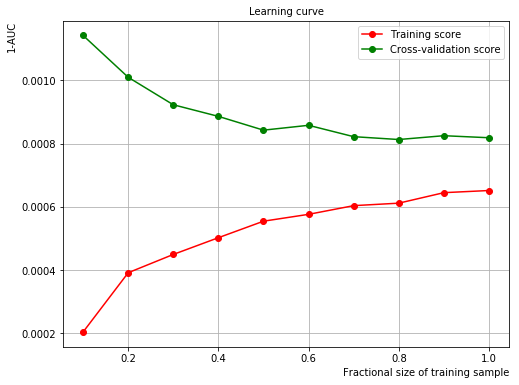

In [96]:
plt.figure(figsize=(8,6))
plt.title("Learning curve", fontsize=10)
plt.plot(trainpoints, learningcurveAUCs["train"], 'o-', color="r",
    label="Training score")
plt.plot(trainpoints, learningcurveAUCs["test"], 'o-', color="g",
    label="Cross-validation score")
plt.xlabel('Fractional size of training sample',horizontalalignment='right',x=1)
plt.ylabel("1-AUC",horizontalalignment='right',y=1)
plt.legend(loc="upper right")
plt.grid()
plt.savefig("results/learningcurve_opt_w06.png")
plt.show()

### Optimise hyperparameters

In [23]:
lc_clf.getParamGrid()

AttributeError: 'GradientBoostingClassifier' object has no attribute 'getParamGrid'

In [32]:
#test = np.empty(len(self.method.estimators_))
test=[]
train = []
for pred in classifier.staged_predict_proba(X_test):
    test.append(1.-roc_auc_score(y_test, pred[:,1], sample_weight=w_test))
for pred in classifier.staged_predict_proba(X_train):
    train.append(1.-roc_auc_score(y_train, pred[:,1], sample_weight=w_train))

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

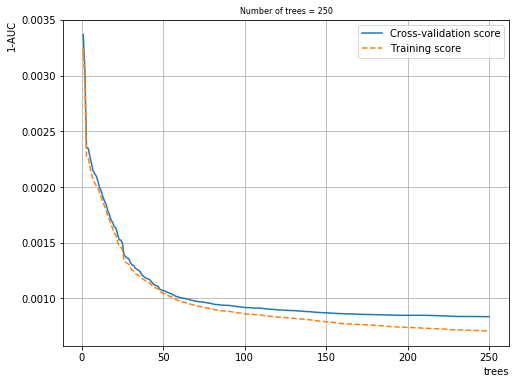

In [33]:
plt.figure(figsize=(8,6))
plt.title("Number of trees = 250", fontsize=8)
x_trees=np.arange(1,251)
print(x_trees)
plt.plot(x_trees,test,'-',label='Cross-validation score')
plt.plot(x_trees,train,'--',label='Training score')
plt.grid()
plt.legend(loc='best')
plt.xlabel("trees",horizontalalignment='right',x=1)
plt.ylabel("1-AUC",horizontalalignment='right',y=1)
plt.show()

### Early stopping test

In [42]:
¬scikitlearn -V
#n_iter_no_change=5, tol=0.01
#classifier=getBDT(options={"n_iter_no_change":15}) 
#getBDT(options={"learning_rate":itrain})
#classifier.fit(X_train,y_train, sample_weight = w_train)
gbes = GradientBoostingClassifier(n_estimators=150, tol=0.01,
                                               random_state=0)

SyntaxError: invalid character in identifier (<ipython-input-42-84bf94654e21>, line 1)

In [32]:
#test = np.empty(len(self.method.estimators_))
test=[]
train = []
for pred in classifier.staged_predict_proba(X_test):
    test.append(1.-roc_auc_score(y_test, pred[:,1], sample_weight=w_test))
for pred in classifier.staged_predict_proba(X_train):
    train.append(1.-roc_auc_score(y_train, pred[:,1], sample_weight=w_train))

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

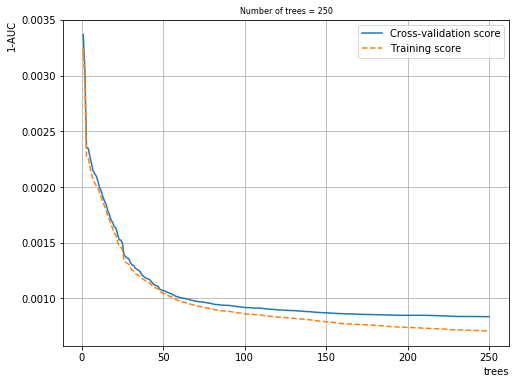

In [33]:
plt.figure(figsize=(8,6))
plt.title("Number of trees = 250", fontsize=8)
x_trees=np.arange(1,251)
print(x_trees)
plt.plot(x_trees,test,'-',label='Cross-validation score')
plt.plot(x_trees,train,'--',label='Training score')
plt.grid()
plt.legend(loc='best')
plt.xlabel("trees",horizontalalignment='right',x=1)
plt.ylabel("1-AUC",horizontalalignment='right',y=1)
plt.show()

### Optimise learining rate

In [18]:
learning_rates = [0.05,0.1,0.15,0.2,0.25]
learningratesAUCs = {}
for itrain in learning_rates:
    learningratesAUCs[itrain]=[]
    lr_clf=getBDT(options={"learning_rate":itrain})
    print("For learning_rate =",itrain,time.ctime(),end="")
    lr_clf.fit(X_train,y_train, sample_weight = w_train)
    print("-->",time.ctime())
    for pred in lr_clf.staged_predict_proba(X_test):
        learningratesAUCs[itrain].append(1.-roc_auc_score(y_test, pred[:,1], sample_weight=w_test))

For learning_rate = 0.05 Sun Jul  7 13:16:36 2019--> Sun Jul  7 13:22:28 2019
For learning_rate = 0.1 Sun Jul  7 13:23:08 2019--> Sun Jul  7 13:29:01 2019
For learning_rate = 0.15 Sun Jul  7 13:29:44 2019--> Sun Jul  7 13:35:38 2019
For learning_rate = 0.2 Sun Jul  7 13:36:22 2019--> Sun Jul  7 13:42:14 2019
For learning_rate = 0.25 Sun Jul  7 13:42:58 2019--> Sun Jul  7 13:48:46 2019


In [20]:
dump(learningratesAUCs,"models/learningratesAUCs_w06.sav")
#learningratescurveAUCs=load("models/learningratesAUCs_w06.sav")

['models/learningratesAUCs_w06.sav']

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

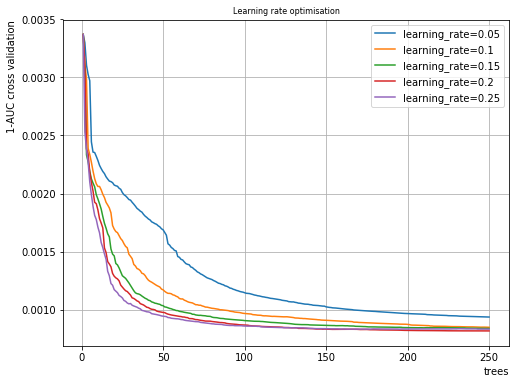

In [26]:
plt.figure(figsize=(8,6))
plt.title("Learning rate optimisation", fontsize=8)
x_trees=np.arange(1,251)
print(x_trees)
for itrain in learning_rates:
    plt.plot(x_trees,learningratesAUCs[itrain],label='learning_rate='+str(itrain))
plt.grid()
plt.legend(loc='best')
plt.xlabel("trees",horizontalalignment='right',x=1)
plt.ylabel("1-AUC cross validation",horizontalalignment='right',y=1)
plt.show()

### Optimise max depth

In [44]:
learning_depths = [2,3,4,5,6]
learningdepthsAUCs={}
for itrain in learning_depths:
    learningdepthsAUCs[itrain]=[]
    ld_clf=getBDT(options={"max_depth":itrain})
    print("For learning_rate =",itrain,time.ctime(),end="")
    ld_clf.fit(X_train,y_train, sample_weight = w_train)
    print("-->",time.ctime())
    for pred in ld_clf.staged_predict_proba(X_test):
        learningdepthsAUCs[itrain].append(1.-roc_auc_score(y_test, pred[:,1], sample_weight=w_test))

For learning_rate = 2 Sun Jul  7 15:49:26 2019--> Sun Jul  7 15:51:46 2019
For learning_rate = 3 Sun Jul  7 15:52:26 2019--> Sun Jul  7 15:55:58 2019
For learning_rate = 4 Sun Jul  7 15:56:39 2019--> Sun Jul  7 16:01:13 2019
For learning_rate = 5 Sun Jul  7 16:01:55 2019--> Sun Jul  7 16:07:57 2019
For learning_rate = 6 Sun Jul  7 16:08:40 2019--> Sun Jul  7 16:15:30 2019


In [45]:
dump(learningdepthsAUCs,"models/learningdepthsAUCs_w06.sav")
#learningdepthsAUCS=load("models/learningdepthsAUCs_w06.sav")

['models/learningdepthsAUCs_w06.sav']

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

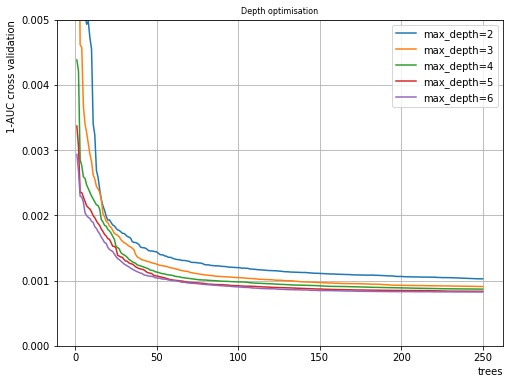

In [49]:
plt.figure(figsize=(8,6))
plt.title("Depth optimisation", fontsize=8)
x_trees=np.arange(1,251)
print(x_trees)
for itrain in learning_depths:
    plt.plot(x_trees,learningdepthsAUCs[itrain],label='max_depth='+str(itrain))
plt.grid()
plt.legend(loc='best')
plt.xlabel("trees",horizontalalignment='right',x=1)
plt.ylabel("1-AUC cross validation",horizontalalignment='right',y=1)
plt.ylim(0,0.005)
plt.show()

### Trying mixed configurations

In [ ]:
learning_comb = {"learningr=0.13,depth=3"}


In [44]:
learning_depths = [2,3,4,5,6]
learningdepthsAUCs={}
for itrain in learning_depths:
    learningdepthsAUCs[itrain]=[]
    ld_clf=getBDT(options={"max_depth":itrain})
    print("For learning_rate =",itrain,time.ctime(),end="")
    ld_clf.fit(X_train,y_train, sample_weight = w_train)
    print("-->",time.ctime())
    for pred in ld_clf.staged_predict_proba(X_test):
        learningdepthsAUCs[itrain].append(1.-roc_auc_score(y_test, pred[:,1], sample_weight=w_test))

For learning_rate = 2 Sun Jul  7 15:49:26 2019--> Sun Jul  7 15:51:46 2019
For learning_rate = 3 Sun Jul  7 15:52:26 2019--> Sun Jul  7 15:55:58 2019
For learning_rate = 4 Sun Jul  7 15:56:39 2019--> Sun Jul  7 16:01:13 2019
For learning_rate = 5 Sun Jul  7 16:01:55 2019--> Sun Jul  7 16:07:57 2019
For learning_rate = 6 Sun Jul  7 16:08:40 2019--> Sun Jul  7 16:15:30 2019


In [45]:
dump(learningdepthsAUCs,"models/learningdepthsAUCs_w06.sav")
#learningdepthsAUCS=load("models/learningdepthsAUCs_w06.sav")

['models/learningdepthsAUCs_w06.sav']

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

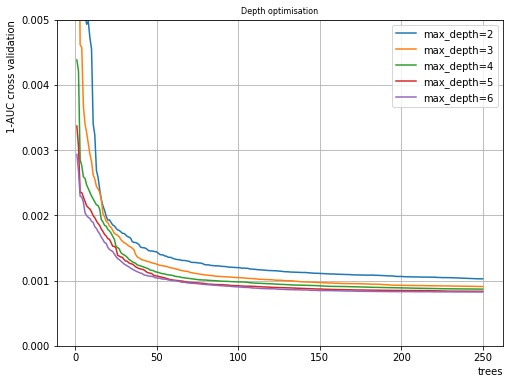

In [49]:
plt.figure(figsize=(8,6))
plt.title("Depth optimisation", fontsize=8)
x_trees=np.arange(1,251)
print(x_trees)
for itrain in learning_depths:
    plt.plot(x_trees,learningdepthsAUCs[itrain],label='max_depth='+str(itrain))
plt.grid()
plt.legend(loc='best')
plt.xlabel("trees",horizontalalignment='right',x=1)
plt.ylabel("1-AUC cross validation",horizontalalignment='right',y=1)
plt.ylim(0,0.005)
plt.show()

### ROC curve and BDT score a la TMVA

In [73]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1], sample_weight = w_test )
roc_auc = auc(fpr,tpr,reorder=True)
print(roc_auc, 1.-roc_auc)

0.9991817876186232 0.0008182123813768039


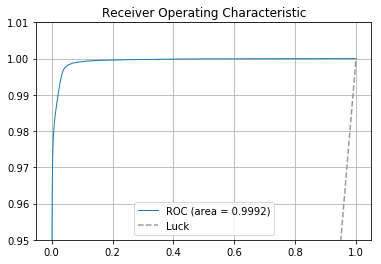

In [74]:
plt.plot(fpr,tpr,lw=1, label='ROC (area = %0.4f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([0.95, 1.01])
plt.title('Receiver Operating Characteristic')
plt.legend(loc="best")
plt.grid()

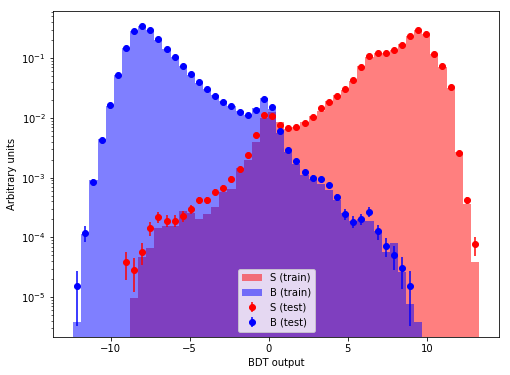

In [77]:
bins = 50
decisions = []
for X,y in ((X_train, y_train), (X_test, y_test)):
    d1 = classifier.decision_function(X[y>0.5]).ravel()
    d2 = classifier.decision_function(X[y<0.5]).ravel()
    decisions += [d1, d2]
        
low = min(np.min(d) for d in decisions)
high = max(np.max(d) for d in decisions)
low_high = (low,high)
plt.figure(figsize=(8,6))
plt.hist(decisions[0],
        color='r', alpha=0.5, range=low_high, bins=bins,
        histtype='stepfilled', normed=True,
        label='S (train)')
plt.hist(decisions[1],
        color='b', alpha=0.5, range=low_high, bins=bins,
        histtype='stepfilled', normed=True,
        label='B (train)')

hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, normed=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale
   
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, normed=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

plt.xlabel("BDT output")
plt.ylabel("Arbitrary units")
plt.yscale('log')
plt.legend(loc='lower center')
plt.show()